In [1]:
using Random: bitrand
using RestrictedBoltzmannMachines: mean_from_inputs
using RestrictedBoltzmannMachines: sample_from_inputs, inputs_h_from_v
using RestrictedBoltzmannMachines: sample_h_from_v
using DelimitedFiles, LinearAlgebra, Statistics, Random
using RestrictedBoltzmannMachines: RBM, Potts, Binary, ReLU, nsReLU, log_pseudolikelihood, initialize!, pcd!,
    sample_from_inputs, sample_v_from_v, free_energy, onehot_encode, sample_h_from_v
using Statistics: mean, cov, std, var, cor
using LinearAlgebra: norm
const ALPHABET = "ACDEFGHIKLMNPQRSTVWY-"
alphabet_dict = Dict(c => i for (i, c) in enumerate(ALPHABET))
using JLD2
using MultivariateStats
using CairoMakie
using MLJ, MLJLinearModels, CategoricalArrays
using DataFrames
using Logging
using Makie
using Serialization
using MultivariateStats
using XLSX
import Logomaker: Logo
alphabet = collect("ACDEFGHIKLMNPQRSTVWY-")
include("specificity_helpers.jl")

analyze_peptides (generic function with 1 method)

In [2]:
data_Gogl = create_binding_dictionary_Gogl("PDZ_2022.xlsx", "PDZ_2022_final.xlsx", 4)
seqs_Gogl = collect(keys(data_Gogl))
onehot_seq = one_hot_encode(seqs_Gogl, alphabet, alphabet_dict)

data_Stiffler = create_binding_dictionary("output.txt")
seqs_Stiffler = collect(keys(data_Stiffler))
onehot_seq_Stif = one_hot_encode(seqs_Stiffler, alphabet, alphabet_dict)

Ai, L, N = size(onehot_seq)   # 21, 81, 254
p = Ai * L                   # 1701


Skipped rows: 2037


1701

Dataset shape: (21, 81, 532538)
Feature dimension: 1701
Total samples: 532538

Training Incremental PCA...
Computing mean...
Computing covariance matrix...
  Batch 1/107 processed
  Batch 2/107 processed
  Batch 3/107 processed
  Batch 4/107 processed
  Batch 5/107 processed
  Batch 6/107 processed
  Batch 7/107 processed
  Batch 8/107 processed
  Batch 9/107 processed
  Batch 10/107 processed
  Batch 11/107 processed
  Batch 12/107 processed
  Batch 13/107 processed
  Batch 14/107 processed
  Batch 15/107 processed
  Batch 16/107 processed
  Batch 17/107 processed
  Batch 18/107 processed
  Batch 19/107 processed
  Batch 20/107 processed
  Batch 21/107 processed
  Batch 22/107 processed
  Batch 23/107 processed
  Batch 24/107 processed
  Batch 25/107 processed
  Batch 26/107 processed
  Batch 27/107 processed
  Batch 28/107 processed
  Batch 29/107 processed
  Batch 30/107 processed
  Batch 31/107 processed
  Batch 32/107 processed
  Batch 33/107 processed
  Batch 34/107 processed
  B

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


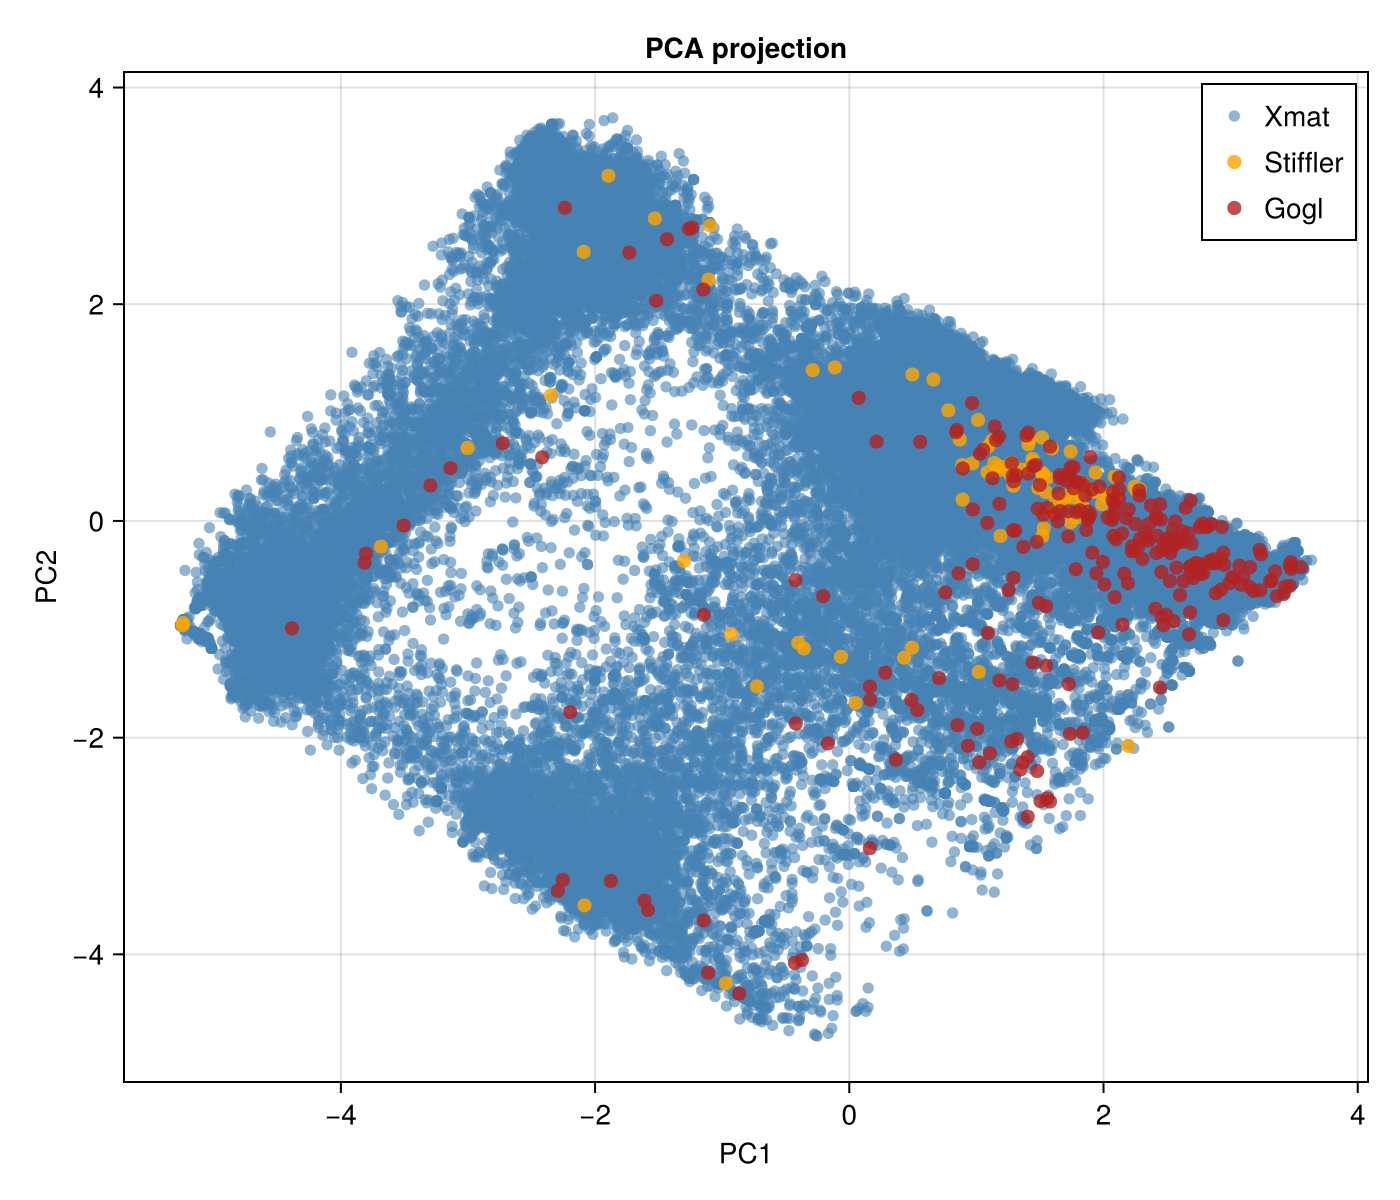

In [3]:
d = deserialize(open("prepped_data.jls"))
X = d[:data]   # 3D: a × b × N

a, b, N = size(X)
feature_dim = a * b
n_components = 2

println("Dataset shape: ($a, $b, $N)")
println("Feature dimension: $feature_dim")
println("Total samples: $N\n")

# ============================================================================
# STEP 2: Incremental PCA Training
# ============================================================================
println("Training Incremental PCA...")

batch_size = 5000
n_batches = ceil(Int, N / batch_size)

# Compute mean incrementally first
println("Computing mean...")
mean_vec = zeros(Float32, feature_dim)
for batch_idx in 1:n_batches
    start_idx = (batch_idx - 1) * batch_size + 1
    end_idx = min(batch_idx * batch_size, N)
    
    for i in start_idx:end_idx
        mean_vec .+= vec(@view X[:, :, i])
    end
end
mean_vec ./= N

# Compute covariance matrix incrementally
println("Computing covariance matrix...")
cov_mat = zeros(Float32, feature_dim, feature_dim)

for batch_idx in 1:n_batches
    start_idx = (batch_idx - 1) * batch_size + 1
    end_idx = min(batch_idx * batch_size, N)
    batch_indices = start_idx:end_idx
    batch_len = length(batch_indices)
    
    # Center the batch
    Xbatch = Matrix{Float32}(undef, feature_dim, batch_len)
    for (k, i) in enumerate(batch_indices)
        Xbatch[:, k] = vec(@view X[:, :, i]) .- mean_vec
    end
    
    # Update covariance
    cov_mat .+= Xbatch * Xbatch'
    
    println("  Batch $batch_idx/$n_batches processed")
end

cov_mat ./= (N - 1)

# Extract principal components
println("\nComputing eigenvectors...")
eigen_result = eigen(Symmetric(cov_mat), feature_dim-n_components+1:feature_dim)
components = eigen_result.vectors[:, end:-1:1]  # Sort by largest eigenvalue
explained_var = eigen_result.values[end:-1:1]

println("Explained variance ratios:")
total_var = sum(eigen_result.values)
for i in 1:n_components
    ratio = explained_var[i] / total_var * 100
    println("  PC$i: $(round(ratio, digits=2))%")
end

# ============================================================================
# STEP 3: Transform Training Data
# ============================================================================
println("\nTransforming training samples...")
nsample_train = min(N, 65000)  # Sample for visualization
idx_train = randperm(N)[1:nsample_train]

Z_train = Matrix{Float32}(undef, n_components, nsample_train)
for (k, i) in enumerate(idx_train)
    sample = vec(@view X[:, :, i]) .- mean_vec
    Z_train[:, k] = components' * sample
    
    if k % 10000 == 0
        println("  Transformed $k/$nsample_train samples")
    end
end

println("Training projection complete: $(size(Z_train))")

# ============================================================================
# STEP 4: Project New/Other Sequences
# ============================================================================
function project_sequences(new_data::Array{Float32, 3}, mean_vec, components)
    a_new, b_new, n_new = size(new_data)
    n_comp = size(components, 2)
    
    # Verify dimensions match
    if a_new * b_new != length(mean_vec)
        error("New data dimensions don't match training data!")
    end
    
    Z_new = Matrix{Float32}(undef, n_comp, n_new)
    
    for i in 1:n_new
        sample = vec(@view new_data[:, :, i]) .- mean_vec
        Z_new[:, i] = components' * sample
    end
    
    return Z_new
end

# Project them
Z_seq = project_sequences(onehot_seq, mean_vec, components)
Z_Stiffler = project_sequences(onehot_seq_Stif, mean_vec, components)

# ============================================================================
# STEP 5: Visualization
# ============================================================================
fig = Figure(resolution = (700, 600))
ax = Axis(
    fig[1, 1],
    xlabel = "PC1",
    ylabel = "PC2",
    title = "PCA projection"
)

# Original data
scatter!(
    ax,
    Z_train[1, :],
    Z_train[2, :];
    color = (:steelblue, 0.6),
    markersize = 8,
    label = "Xmat"
)

# Original data
scatter!(
    ax,
    Z_Stiffler[1, :],
    Z_Stiffler[2, :];
    color = (:orange, 0.8),
    markersize = 10,
    label = "Stiffler"
)

# Sequences
scatter!(
    ax,
    Z_seq[1, :],
    Z_seq[2, :];
    color = (:firebrick, 0.8),
    markersize = 10,
    label = "Gogl"
)

axislegend(ax)
fig

This PCA looks very strange

In [ ]:
save("pca_projection.png", fig)

: 